In [1]:
import uproot
import numpy as np

file1 = uproot.open(f'/storage/data/48PMT/bipo/20230222/run0/tier1/output_dt2.root')
timestamps1 = np.array(file1['eventTree']['timestamp'].array())

file2 = uproot.open(f'/storage/data/48PMT/bipo/20230222/run1/tier1/output_dt2.root')
timestamps2 = np.array(file2['eventTree']['timestamp'].array())

file3 = uproot.open(f'/storage/data/48PMT/bipo/20230223/run0/tier1/output_dt2.root')
timestamps3 = np.array(file3['eventTree']['timestamp'].array())

In [2]:
timestamps2, timestamps3

(array([[     218024792760189,      218024792760189, 18446744073709551615,
         ..., 18446744073709551615, 18446744073709551615,
         18446744073709551615],
        [     218024792760303,      218024792760303,      218024792760303,
         ..., 18446744073709551615, 18446744073709551615,
         18446744073709551615],
        [     218024792760303,      218024792760303,      218024792760303,
         ..., 18446744073709551615, 18446744073709551615,
         18446744073709551615],
        ...,
        [     218883647426727,      218883647426727,      218883647426727,
         ..., 18446744073709551615, 18446744073709551615,
         18446744073709551615],
        [     218883647678529,      218883647678529,      218883647678529,
         ..., 18446744073709551615, 18446744073709551615,
         18446744073709551615],
        [     218883648130601,      218883648130601,      218883648130601,
         ..., 18446744073709551615, 18446744073709551615,
         18446744073709551615

In [3]:
ch = 1
timestamps = np.append(timestamps1[:,ch], timestamps2[:,ch])
timestamps = np.append(timestamps, timestamps3[:,ch])
timestamps = timestamps*8e-9


Nmeds=10
left_shift=100
    
diffs = np.diff(timestamps[left_shift:])
upper_cut = Nmeds*np.median(diffs[diffs>0])
mask = np.logical_and(diffs < upper_cut, diffs > 0)
diffs_masked = diffs[mask]


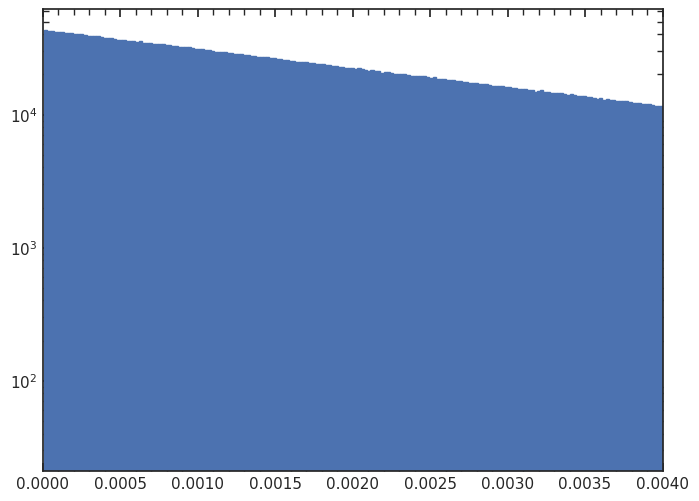

In [4]:
fig, ax = plt.subplots(figsize = (8, 6))

n, edges,_ = ax.hist(diffs_masked, bins = np.linspace(1e-5, diffs_masked.max(), 1000), fc = 'b', ec = 'b')
centers = (edges[1:]+edges[:-1])/2.
ax.set_xlim(0, 200e-6*20)
ax.set_yscale('log')

In [157]:
def my_func(ts, a1, tau1, a2, tau2, c):
    return a1*np.exp(-ts/tau1)+a2*np.exp(-ts/tau2)+c

def chi2(x, mu):
    return ((x-mu)**2/mu).sum()

import iminuit


t_min = 1e-3
t_max = 0.1

mask_fit = np.logical_and(centers>=t_min, centers<=t_max)

def cost_function(theta):
    a1, tau1, a2, tau2, c = theta
    # print(theta)
    y = my_func(centers[mask_fit], a1, tau1, a2, tau2, c)
    return chi2(n[mask_fit], y)

# theta0 = 2000, 0.003, 10, 164e-6/np.log(2), 0.
theta0 = 2000, 0.003, 10, 164e-6/np.log(2), 0
param_names = ['a1', 'tau1', 'a2', 'tau2', 'c']
m = iminuit.Minuit(cost_function, theta0, name = param_names)

m.limits['a1'] = (0, None)
m.limits['a2'] = (0, None)
m.limits['tau1'] = (0, None)
m.limits['tau2'] = (0, None)
m.limits['c'] = (0, None)

m.errordef = m.LEAST_SQUARES
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 897.2                      │              Nfcn = 471              │
│ EDM = 0.000112 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a1   │  32.4e3   │   3.2e3   │            │            │    0    │         │       │
│ 1 │ tau1 │ 3.032e-3  │ 0.030e-3  │            │            │    0    │         │       │
│ 2 │ a2   │  10.8e3   │   3.2e3   │            │            │    0    │         │       │
│ 3 │ tau2 │  3.03e-3  │  0.09e-3  │            │            │    0    │         │       │
│ 4 │ c    │    0.5    │    0.6    │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬───────────────────────────────────────────────────┐
│      │        a1      tau1        a2      tau2         c │
├──────┼───────────────────────────────────────────────────┤
│   a1 │  1.01e+07  -0.00486 -1.01e+07    0.0142        11 │
│ tau1 │  -0.00486  8.75e-10    0.0048 -2.61e-09 -7.71e-07 │
│   a2 │ -1.01e+07    0.0048  1.01e+07   -0.0143     -1.01 │
│ tau2 │    0.0142 -2.61e-09   -0.0143  7.82e-09 -7.39e-07 │
│    c │        11 -7.71e-07     -1.01 -7.39e-07      0.48 │
└──────┴───────────────────────────────────────────────────┘

In [158]:
164e-6/np.log(2)

0.00023660198670579

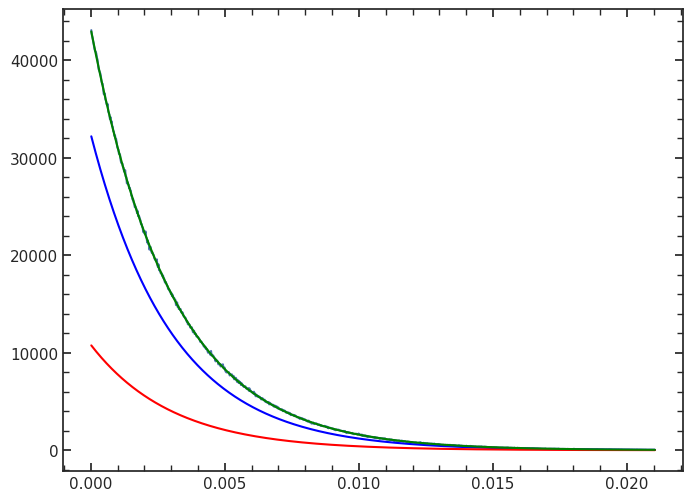

In [159]:
fig, ax = plt.subplots(figsize = (8, 6))
a1, tau1, a2, tau2, c = m.values

ax.plot(centers, n)
ax.plot(centers, a1*np.exp(-centers/tau1), c='blue')
ax.plot(centers, a2*np.exp(-centers/tau2), c='red')
ax.plot(centers, my_func(centers, *m.values), c='green')
# ax.set_xlim(0, 160e-6*8)

#################################################################################

In [63]:
import emcee

emcee.EnsembleSampler

emcee.ensemble.EnsembleSampler

In [64]:
164e-6/np.log(2)

0.00023660198670579

In [25]:
m.values

<ValueView a1=23130.932986122836 tau1=0.0030316643257630137 a2=20117.491021207683 tau2=0.003032384100234629 c=0.4849370280747811>

In [71]:
def my_func(ts, a1, tau1, c):
    return a1*np.exp(-ts/tau1)+c

def chi2(x, mu):
    return ((x-mu)**2/mu).sum()

import iminuit


t_min = 1e-2
t_max = 0.1

mask_fit = np.logical_and(centers>=t_min, centers<=t_max)

def cost_function(theta):
    a1, tau1, c = theta
    # print(theta)
    y = my_func(centers[mask_fit], a1, tau1, c)
    return chi2(n[mask_fit], y)

theta0 = 2000, 0.003, 0.
param_names = ['a1', 'tau1', 'c']
m = iminuit.Minuit(cost_function, theta0, name = param_names)

m.limits['a1'] = (0, None)
m.limits['tau1'] = (0, None)
m.limits['c'] = (0, None)

m.errordef = m.LEAST_SQUARES
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 495.7                      │              Nfcn = 307              │
│ EDM = 6.15e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a1   │  42.6e3   │   0.9e3   │            │            │    0    │         │       │
│ 1 │ tau1 │ 3.040e-3  │ 0.017e-3  │            │            │    0    │         │       │
│ 2 │ c    │    0.7    │    1.1    │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬───────────────────────────────┐
│      │        a1      tau1         c │
├──────┼───────────────────────────────┤
│   a1 │   7.6e+05   -0.0146  1.05e+03 │
│ tau1 │   -0.0146  2.85e-10 -2.14e-05 │
│    c │  1.05e+03 -2.14e-05      2.08 │
└──────┴───────────────────────────────┘

(0.0, 0.00128)

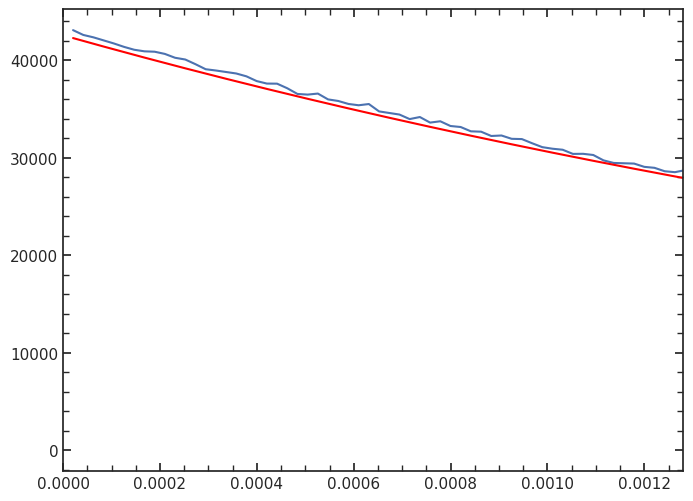

In [73]:
fig, ax = plt.subplots(figsize = (8, 6))
# a1, tau1, a2, tau2, c = m.values
a1, tau1, c = m.values

ax.plot(centers, n)
# ax.plot(centers, a1*np.exp(-centers/tau1))
ax.plot(centers, my_func(centers, *m.values), c='red')
ax.set_xlim(0, 160e-6*8)

In [80]:
def my_func(ts, a1, tau1):
    return a1*np.exp(-ts/tau1)

def chi2(x, mu):
    return ((x-mu)**2/mu).sum()

import iminuit


t_min = 0
t_max = 0.002

mask_fit = np.logical_and(centers>=t_min, centers<=t_max)

def cost_function(theta):
    a1, tau1 = theta
    # print(theta)
    y = my_func(centers[mask_fit], a1, tau1)+ 1939.4395590083384*np.exp(-centers[mask_fit]/0.0030102146975778347)+0.41786164731645326
    return chi2(n[mask_fit], y)

theta0 = 100, 236e-6
param_names = ['a1', 'tau1']
m = iminuit.Minuit(cost_function, theta0, name = param_names)

m.limits['a1'] = (0, None)
m.limits['tau1'] = (0, None)

m.errordef = m.LEAST_SQUARES
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 937.7                      │              Nfcn = 83               │
│ EDM = 1.01e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a1   │   55.5    │    3.4    │            │            │    0    │         │       │
│ 1 │ tau1 │  2.13e-3  │  0.28e-3  │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬─────────────────────┐
│      │        a1      tau1 │
├──────┼─────────────────────┤
│   a1 │      11.6 -0.000802 │
│ tau1 │ -0.000802  8.06e-08 │
└──────┴─────────────────────┘

In [1]:
import uproot
import json
import numpy as np
from vis_functions import *
from rate_estim import *
from tqdm import tqdm

notebook_type = "rates"
params_file = open("/home/juno/arsgav/params.json")
PARAMS = json.load(params_file)
PARAMS['type'] = notebook_type

neptune_run = False
if neptune_run:
    run = neptune.init_run(
        project="legnaro/LegnaroSetup",
        api_token=PARAMS['api_token'],
        tags=[
            PARAMS['path'],
            PARAMS['run_numbers'],
            PARAMS['source_names'],
            PARAMS['output_file'],
            notebook_type,
        ],
        name="LNL",
    )
    
    del PARAMS['api_token']    
    run['PARAMS'] = PARAMS

In [2]:
runs_list = ["run0 - Bkg"]

In [5]:
run_numbers = PARAMS['run_numbers'].split(', ')
path = PARAMS['path']
output_file = PARAMS['output_file']
left_shift = int(PARAMS['left_shift'])

In [6]:
path

'/storage/data/48PMT/bipo/20230222/'

In [4]:
rates_array = []
fit_params_array = []
distrs_array = []

channel_number = np.random.randint(45)
rate_estim_outputs = np.array(
    [rate_estim(path, run_number, output_file, channel_number, Nmeds=10, left_shift=left_shift) for run_number in run_numbers],
    dtype=object
)

rates = rate_estim_outputs[:, 0]
fit_params = rate_estim_outputs[:, 1]
distrs = rate_estim_outputs[:, 2]
channel_number

10

## Rates visualization: 

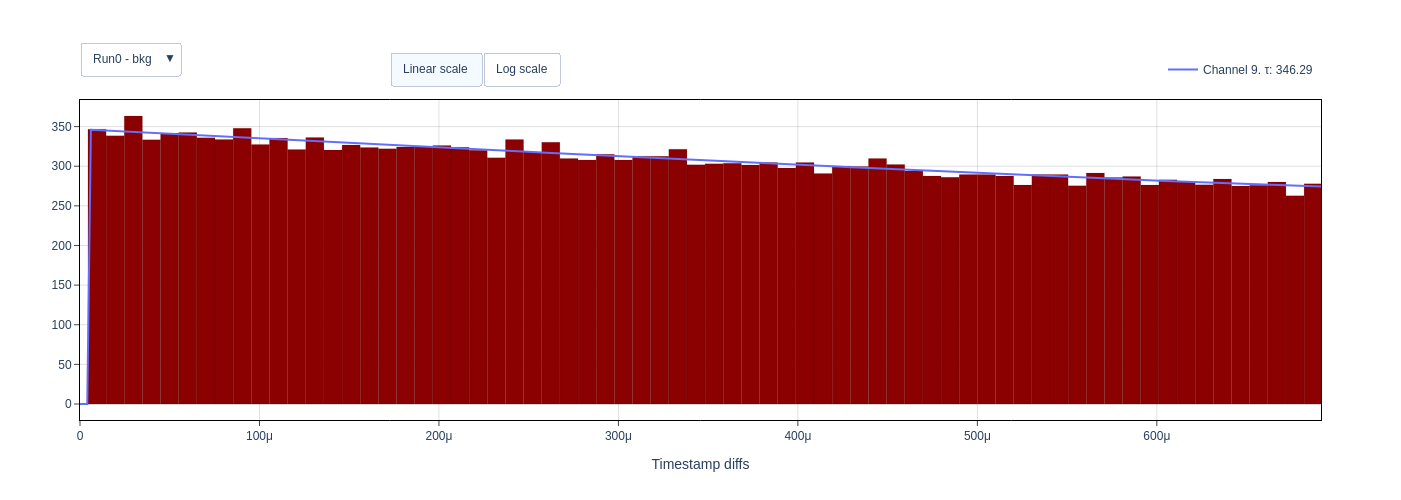

In [8]:
if neptune_run:
    rates_fit_plots(run_numbers, runs_list, distrs, fit_params, rates, channel_number,
                    Nbins=1000, line_width=0.1, height=500, width=950,
                    neptune_run=neptune_run, run=run,
                    run_plot_name=f"Rate by channel for {PARAMS['run_numbers']} runs")
else:
    rates_fit_plots(run_numbers, runs_list, distrs, fit_params, rates, channel_number,
                    Nbins=1000, line_width=0.1, height=500, width=950,)

In [6]:
if neptune_run:
    run.stop()